In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graph_tool as gt
import csv
from sklearn.decomposition import PCA
import time 
import itertools

folder_path = "/Users/endingalaporte/Desktop/graphlet_degree_kernel"
input_path = folder_path + "/input"
output_path = folder_path + "/output"


#core

def x9_counts(a : list,b : list,c):
    """given a b c respectively lists Su, Sv and count x7 integer, returns integer count x9"""
    if len(a)>=2 and len(b) >= 2:
        x9_count = k_parmi_n(2, len(a)) + k_parmi_n(2, len(b)) - c
    if len(a)<2 or len(b) <2:
        x9_count = 0
    if x9_count <0:
        x9_count = 0
    return x9_count
    
def x6_count(a : list, b):
        """given a and b, where a is list Te and b is count integer x5, returns counts x6"""
        if len(a) >= 2:
            x6_count = k_parmi_n(2, len(tuple(a))) - b
        if len(a) < 2:
            x6_count = 0
        return x6_count
    
def update_vertices_including(old_array : np.ndarray, v1 : gt.libgraph_tool_core.Vertex):
    """given array and vertex object, return array including one time the vertex"""
    if v1 not in old_array:
        new_array = np.append(old_array, v1)
    if v1 in old_array:
        new_array = old_array
    return(new_array)

def update_vertices_without(old_array : np.ndarray, v1 : gt.libgraph_tool_core.Vertex):
    """given array and vertex object, returns array without the object"""
    new_array = old_array[old_array != v1]
    return(new_array)

def k_parmi_n(k,n):
    """binomial coefficient k parmi n"""
    num = np.math.factorial(n)
    denom = np.math.factorial(k)*np.math.factorial(n-k)
    return num/denom

def d(w):
    """given vertex w, returns its total degree"""
    return (w.in_degree() + w.out_degree())

def S_set(e : gt.libgraph_tool_core.Edge, w : gt.libgraph_tool_core.Vertex):
    """given edge e and w vertex, gives set Sw"""
    Sw = []
    v = e.source()
    u = e.target()
    neigh_w = list(w.all_neighbors())
    if w == v: #Sv
        neigh_w.remove(u)
    if w == u: #Su
        neigh_w.remove(v)
    for w in neigh_w:
        Sw.append(w)
    return Sw

def Te_set(e : gt.libgraph_tool_core.Edge):
    """given graph G and edge e, returns set of vertices Te that form triangles with edge e"""
    v = e.source()
    u = e.target()
    Te = []
    
    #create iterator over all vertex neighbors of v and u, remove repeated vertex, remove v and u
    ite_without_repeat = list(itertools.chain(v.all_neighbors(), u.all_neighbors()))
    for w in v.all_neighbors():
        if w in u.all_neighbors():
            ite_without_repeat.remove(w)
    ite_without_repeat.remove(u) #should remove u and v from this, otherwise we test
    ite_without_repeat.remove(v) #if u is in u and it is, but can be triangle with itself
    
    #create Te set of vertices following math definition of the set Te    
    for w in ite_without_repeat:
        if (w in v.all_neighbors()) and (w in u.all_neighbors()):
            Te.append(w)
    return(Te)

def LOCALGRAPHLET(G : gt.Graph, e : gt.libgraph_tool_core.Edge):
    """given graph G and edge e, returns graphlet G1,G2,G5,G6,G7,G8,G9,G10 degree vector of the edge"""
    #graphlet counts
    x5 = 0
    x7 = 0
    x8 = 0
    sigma = 0
    
    #lookup table is a dictionnary
    psi = dict()
    
    #vertices objects and sets of vertices objects e = (v, u) #not (u, v) order matters
    v = e.source()
    u = e.target()
    Sv = S_set(e, v)
    Su = S_set(e, u)
    
    #set of edge objects
    Te = Te_set(e) 
    
    avant = len(Te)
    #count graphlets x5, x7, x8 directly in graph
    for w in v.all_neighbors():
        if w != u: #line 3
            Sv = update_vertices_including(np.array(Sv, dtype = gt.libgraph_tool_core.Vertex), w).tolist()
            psi[w] = 'lambda1'
    for w in u.all_neighbors():
        if w != v: #line 5
            if (w in psi.keys()) == True: 
                if psi[w] == 'lambda1': #careful to check w is a key of dictionnary psi before calling value psi[w]
                    Te = update_vertices_including(np.array(Te, dtype = gt.libgraph_tool_core.Vertex), w).tolist() 
                    psi[w] = 'lambda3'   
                    Sv = update_vertices_without(np.array(Sv, dtype = gt.libgraph_tool_core.Vertex), w).tolist()
            if ((w in psi.keys()) == True and psi[w] != 'lambda') or (w not in psi.keys()):  
                Su = update_vertices_including(np.array(Su, dtype = gt.libgraph_tool_core.Vertex), w).tolist()
                psi[w] = 'lambda2'
    for w in Te:
        for r in w.all_neighbors():
            if (r in psi.keys()) == True:
                if psi[r] == 'lambda3':
                    x5 = x5 +1
                psi[w] = 'lambda4'
    for w in Su:
        for r in w.all_neighbors():
            if (r in psi.keys()) == True:
                if psi[r] == 'lambda1':
                    x8 = x8 + 1
                if psi[r] == 'lambda2':
                    x7 = x7 + 1
                if psi[r] == 'lambda4':
                    sigma = sigma + 1
        psi[w] = 0
    for w in Sv:
        for r in w.all_neighbors():
            if (r in psi.keys()) == True: #is it necessary to check if r in psi.keys() here? Did we did it just before?
                if psi[r] == 'lambda1':
                    x7 = x7 + 1
                if psi[r] == 'lambda4':
                    sigma = sigma + 1
        psi[w] = 0
    
    #graphlets counts x1, x2, x6, x9, x10 deduced
    
    x1 = len(Te)
    x2 = (d(u) + d(v) - 2) - 2*len(Te) #sometimes get negative counts
    #x2 = len(Su) + len(Sv)
    x6 = x6_count(Te, x5)
    #delete that line if x6 works without x6 = k_parmi_n(2, len(tuple(Te))) - x5 #need to solve, (k parmi n) for n >=k, otherwise negative factorial is impossible
    x9 = x9_counts(Su, Sv, x7)
    #delete that line if x6 works without x9 x9 = k_parmi_n(2, len(Sv)) + k_parmi_n(2, len(Su)) - x7
    x10 = (len(Sv)*len(Su)) - x8
    
    after = len(Te)
    return(np.array([x1, x2, x5, x6, x7, x8, x9, x10], dtype = int))
                     #'Te',len(Te),'Sv',len(Sv),'Su',len(Su),"Te avant",avant,"et after",after], dtype = object))

def matrix_count(G : gt.Graph, draw):
    "given graph G object, draw G and returns matrix of graph degree for each edge"
    if draw == 'yes':
        size = 120*int(math.log(1 + len(tuple(G.edges()))))
        gtd.graph_draw(G, edge_text = G.edge_index, edge_font_size = 12, vertex_text=G.vertex_index, vertex_font_size=10, output_size = (size,size))
    if draw == 'no':
        print(G)
    s = time.time()
    matrix = []
    for e in G.edges():
        matrix.append(LOCALGRAPHLET(G, e))
    matrix = np.array(matrix)
    print("duration to compute matrix is =",time.time()-s)
    return matrix


#kernel 
def remove_column(entry):
    """given array, returns the array without the columns filled with zeros"""
    
    def delete_column(array, i):
        """
        given array and i-th column index
        return the array without that i-th column
        """
        array = np.delete(array, i, 1)
        return array
    
    def test_zero(array):
        """given array, return True if it contains only zeros"""
        return np.all(array == 0)
    
    array = []
    for c in range(entry.shape[1]):
        if test_zero(entry[:,c]) == False:
            array.append(entry[:,c])
    array = np.array(array).T
    return array

def hist_d(array : np.ndarray, d):
    """
    given array of integer values,
    returns the histogram of consecutive integer values without hole
    and fill with zeros until "sortie" array is of length d
    """
    bins = np.append(np.arange(0,array.max()+1)-0.5,array.max()+0.5)
    le = len(np.histogram(array, bins = bins)[0])
    h = np.histogram(array, bins = bins)[0][1:le]
    sortie = np.zeros(d)
    l = len(h)
    sortie[0:l] = h[0:d]
    return sortie

def string_to_list(string):
    """given a string of two elements, returns each element in a list"""
    return [int(string.split(' ')[0]), int(string.split(' ')[1])]

def Q_phi(Q : np.ndarray, d_gc):
    """
    given matrix of counts Q and histogram length, 
    returns the phi embedding 
    of consecutive histogram of each graphlet degree
    """
    phi = []
    for i in range(Q.shape[1]):
        h = hist_d(Q[:,i], d_gc)
        
        if h.sum() != 0:
            h = h/h.sum()
            phi.append(h)
        if h.sum() == 0:
            phi.append(np.zeros(d_gc))
    phi= np.concatenate(np.array(phi))
    return phi

In [87]:
#import labels

n = 136 #nb of cities

label_path = input_path + '/country_binary.txt'
text = open(label_path, encoding = 'utf-16')
reader = csv.reader(text, delimiter='\n')
labels = np.array([int(row[0]) for row in reader])

#import graphs
print("step 1")
s = time.time()
G_list = np.array([gt.Graph(directed = False) for i in range(n)], dtype = object)
o_f = input_path
for i in range(n):
    open_path = o_f + "/edgelist_city"+str(i)+".txt"
    #print(open_path)
    text = open(open_path, 'r')
    reader = csv.reader(text, delimiter='\n')
    elist = [string_to_list(row[0]) for row in reader]
    G_list[i].add_edge_list(elist)   
print(len(G_list),"cities imported")

step 1
136 cities imported


In [3]:
#embed each graph into matrix of count Q
print("step 2, t=", time.time()-s)
s = time.time()
all_Q = []
b = 0

for g in G_list:
    all_Q.append(matrix_count(g, draw = 'no'))
    print(b, "-135")
    b = b +1
    
all_Q = np.array(all_Q)
print(time.time()-s)

step 2, t= 11.820554971694946
<Graph object, undirected, with 2744 vertices and 3454 edges at 0x10d619df0>
duration to compute matrix is = 3.720720052719116
0 -135
<Graph object, undirected, with 1662 vertices and 2187 edges at 0x1469e0670>
duration to compute matrix is = 2.339001178741455
1 -135
<Graph object, undirected, with 4240 vertices and 6000 edges at 0x1469e0910>
duration to compute matrix is = 6.918490171432495
2 -135
<Graph object, undirected, with 2590 vertices and 3510 edges at 0x1469e0c10>
duration to compute matrix is = 4.124659299850464
3 -135
<Graph object, undirected, with 2474 vertices and 3257 edges at 0x1469e0f10>
duration to compute matrix is = 3.7532260417938232
4 -135
<Graph object, undirected, with 6695 vertices and 8213 edges at 0x1469e1250>
duration to compute matrix is = 8.845562934875488
5 -135
<Graph object, undirected, with 6572 vertices and 8736 edges at 0x1469e15b0>
duration to compute matrix is = 10.020473957061768
6 -135
<Graph object, undirected, wit

duration to compute matrix is = 7.36039400100708
60 -135
<Graph object, undirected, with 2312 vertices and 3223 edges at 0x10d785dc0>
duration to compute matrix is = 3.2958271503448486
61 -135
<Graph object, undirected, with 5130 vertices and 7167 edges at 0x10d785130>
duration to compute matrix is = 7.216615915298462
62 -135
<Graph object, undirected, with 9727 vertices and 13811 edges at 0x10d788310>
duration to compute matrix is = 16.643871068954468
63 -135
<Graph object, undirected, with 7478 vertices and 10609 edges at 0x10d788610>
duration to compute matrix is = 14.998824119567871
64 -135
<Graph object, undirected, with 4179 vertices and 5693 edges at 0x10d788910>
duration to compute matrix is = 6.2874860763549805
65 -135
<Graph object, undirected, with 11796 vertices and 16509 edges at 0x10d788c10>
duration to compute matrix is = 19.70664119720459
66 -135
<Graph object, undirected, with 18700 vertices and 27431 edges at 0x10d788f10>
duration to compute matrix is = 35.84901690483

duration to compute matrix is = 139.09816193580627
120 -135
<Graph object, undirected, with 18520 vertices and 28082 edges at 0x146a77430>
duration to compute matrix is = 30.63823413848877
121 -135
<Graph object, undirected, with 33083 vertices and 47890 edges at 0x146a77730>
duration to compute matrix is = 51.06040287017822
122 -135
<Graph object, undirected, with 29821 vertices and 41831 edges at 0x146a77a30>
duration to compute matrix is = 43.74606513977051
123 -135
<Graph object, undirected, with 37752 vertices and 55067 edges at 0x146a77d30>
duration to compute matrix is = 58.80735516548157
124 -135
<Graph object, undirected, with 30718 vertices and 44074 edges at 0x146a7a070>
duration to compute matrix is = 46.6583411693573
125 -135
<Graph object, undirected, with 57732 vertices and 82519 edges at 0x146a7a370>
duration to compute matrix is = 85.933100938797
126 -135
<Graph object, undirected, with 47206 vertices and 69856 edges at 0x146a7a670>
duration to compute matrix is = 76.3

<ipython-input-3-0d0a63b6944e>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_Q = np.array(all_Q)


In [9]:
3512.6508519649506/60

58.544180866082506

In [4]:
storage = all_Q

In [5]:
second_storage = all_Q #will be usefull for ploting choice 2 not standardized 

In [33]:
all_phi.shape

(136, 112)

step 3, t= 16962.969398975372
max count accross all cities is d_gc = 47
before removing columns of zeros, all_phi of shape (136, 376)
after, shape is  (136, 112)
step 4, t =  16965.100420951843
0 column(s) of all_phi with std = 0


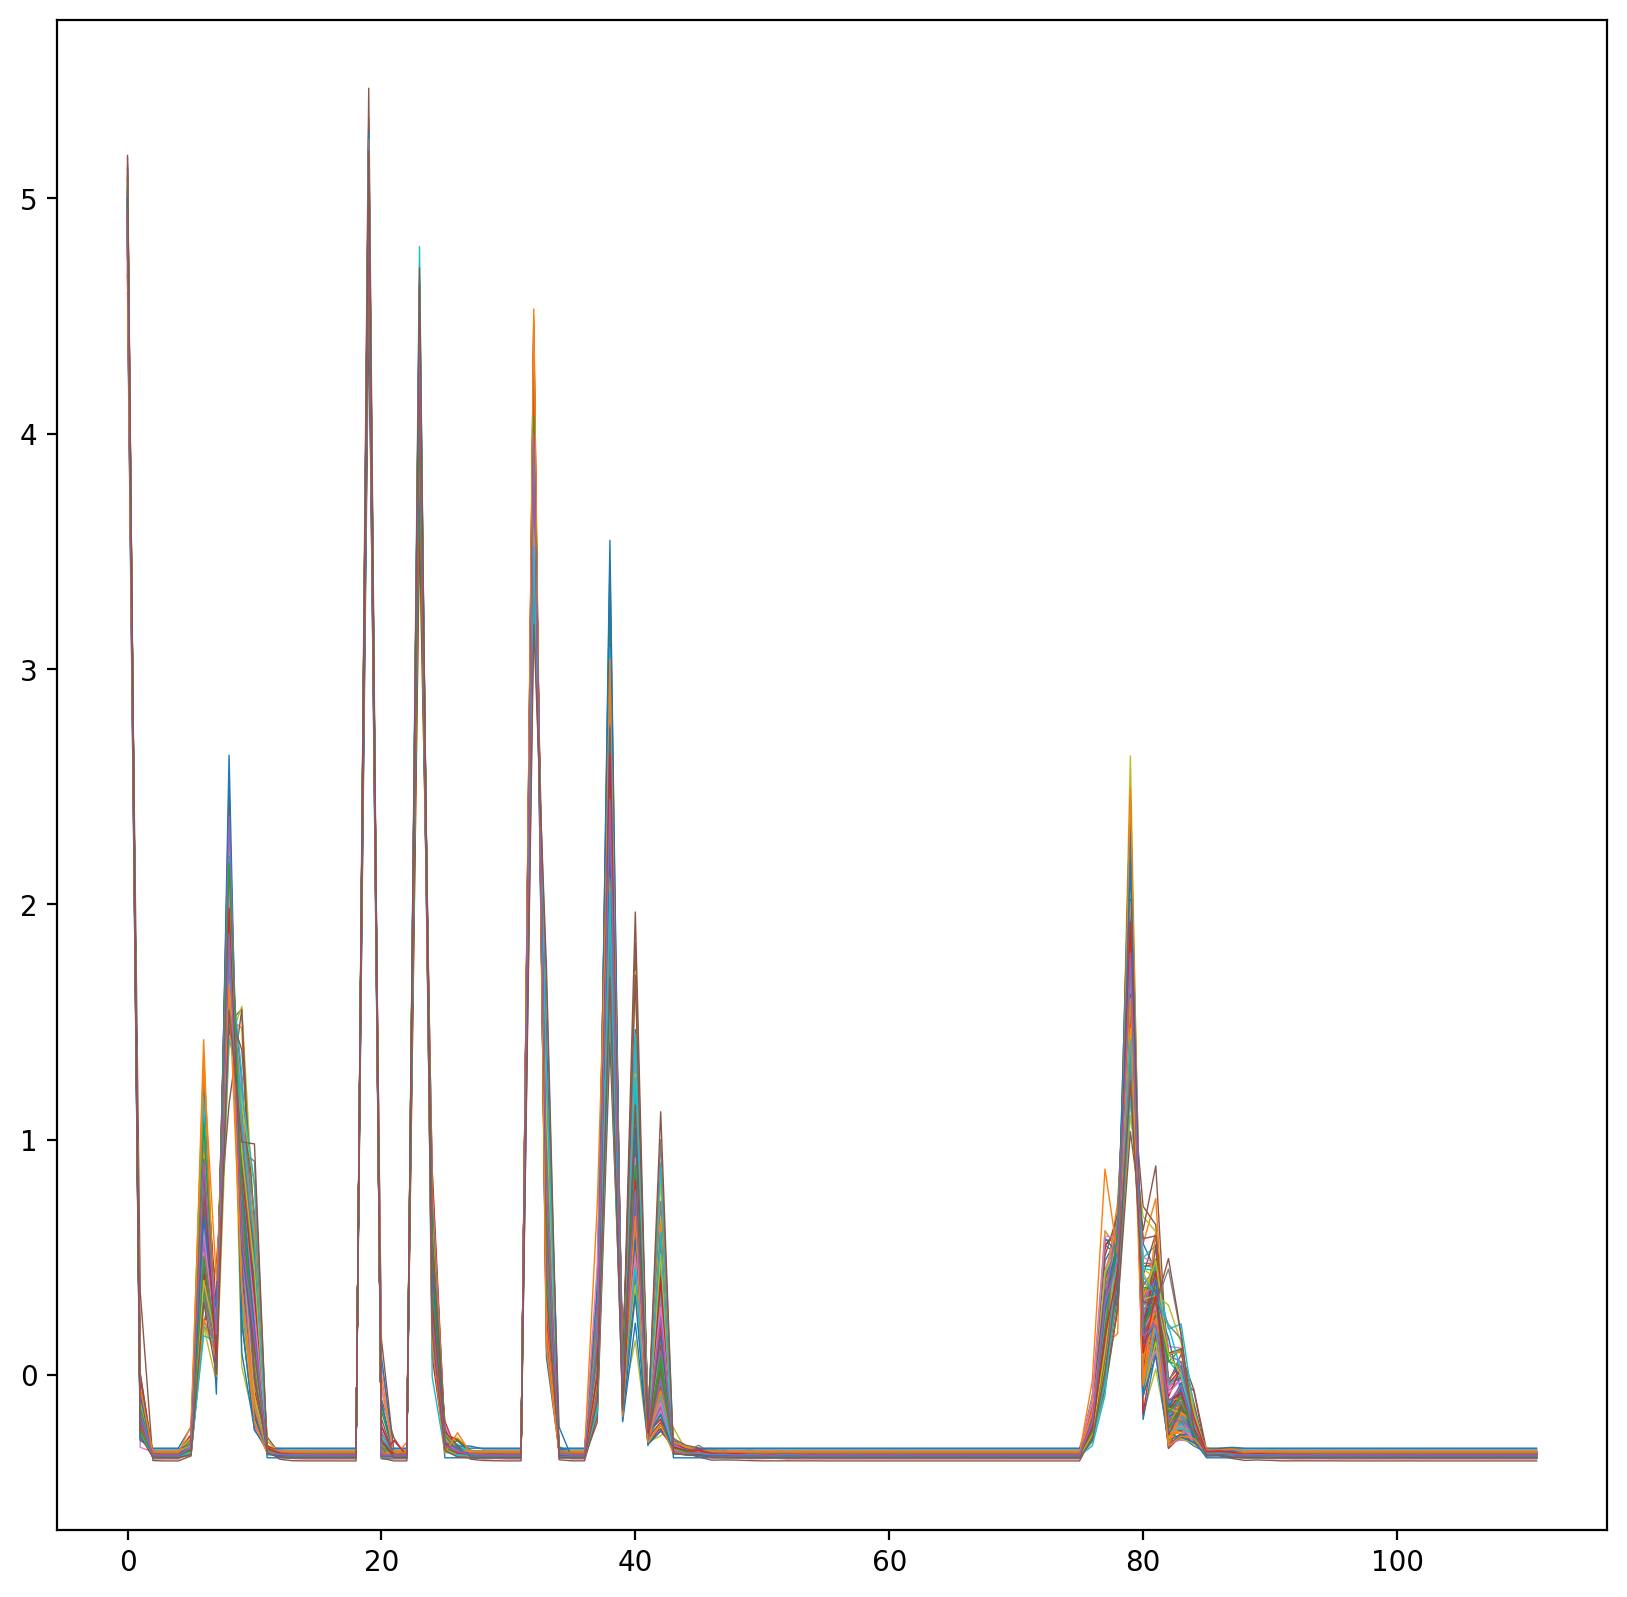

In [43]:
#transform each Q into phi
print("step 3, t=", time.time()-s)

d_gc = np.concatenate(all_Q).max()
print("max count accross all cities is d_gc =",d_gc)

all_phi = []
for q in all_Q:
    all_phi.append(Q_phi(q, d_gc))
    
all_phi = np.array(all_phi)

#save it in case
np.savetxt(output_path + "/all_phi.txt",all_phi)
print("before removing columns of zeros, all_phi of shape",all_phi.shape)
all_phi = remove_column(all_phi)
print("after, shape is ",all_phi.shape)

# Choice 1 'standardize'
# choice 2 'non standardize'

choice = 'standardize'

if choice == 'standardize':
    for i in range(len(all_phi)):
        if all_phi[i].std !=0:
            all_phi[i] =  (all_phi[i]- all_phi[i].mean())/ all_phi[i].std()
        if all_phi[i].std == 0:
            all_phi[i] =  all_phi[i]- all_phi[i].mean()

#visualize each phi
print("step 4, t = ", time.time()-s)

plt.figure(figsize = (10,10), dpi = 200)
for each in all_phi:
    plt.plot(each, linewidth=0.5)
plt.savefig(output_path+"/graphlet_degree_normalized_standardized_allphi.svg")


#count the number c of std = 0 accross each column of all_phi
all_phi = all_phi

all_phi.shape[1]

std = []
for j in range(all_phi.shape[1]):
    std.append(all_phi[:,j].std())
std = np.array(std)

c = 0
for i in std == 0:
    if i == True:
        c = c+1
print(c,"column(s) of all_phi with std = 0")

In [78]:
#kernel matrix
K = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        K[i,j] = np.dot(all_phi[i], all_phi[j])

#PCA

reducer = PCA(n_components = 3)
embed = reducer.fit_transform(K)
plt.figure(figsize = (5,5), dpi = 200)
plt.scatter(embed[:,0], embed[:,1], c = labels, facecolors='none')
plt.savefig(output_path + 'graphlet_degree_normalized_standardized_PCA01.svg')
plt.figure(figsize = (5,5), dpi = 200)
plt.scatter(embed[:,1], embed[:,2], c = labels,facecolors='none')
plt.savefig(output_path + 'graphlet_degree_normalized_standardized_PCA12.svg')
plt.figure(figsize = (5,5), dpi = 200)
plt.scatter(embed[:,2], embed[:,0], c = labels, facecolors='none')
plt.savefig(output_path + 'graphlet_degree_normalized_standardized_PCA20.svg')

In [90]:
labels = np.array(labels, dtype = object)
for i in range(len(labels)):
    if labels[i] == 0:
        labels[i] = 'C0'
    if labels[i] == 1:
        labels[i] = 'C1'

In [95]:
#3D plots of three components of PCA

#%matplotlib #interactive plot
from mpl_toolkits import mplot3d
import numpy as np
plt.ion()

x, y, z = embed[:,0], embed[:,1], embed[:,2]

fig = plt.figure() #figsize = (8,6), dpi = 300
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = z
xline = x
yline = y
angle = 120
ax.view_init(20, angle)
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')
ax.scatter(xline, yline, zline, c = labels, s = 30)
plt.savefig(output_path + 'graphlet_degree_normalized_standardized_3D_PCA.svg')

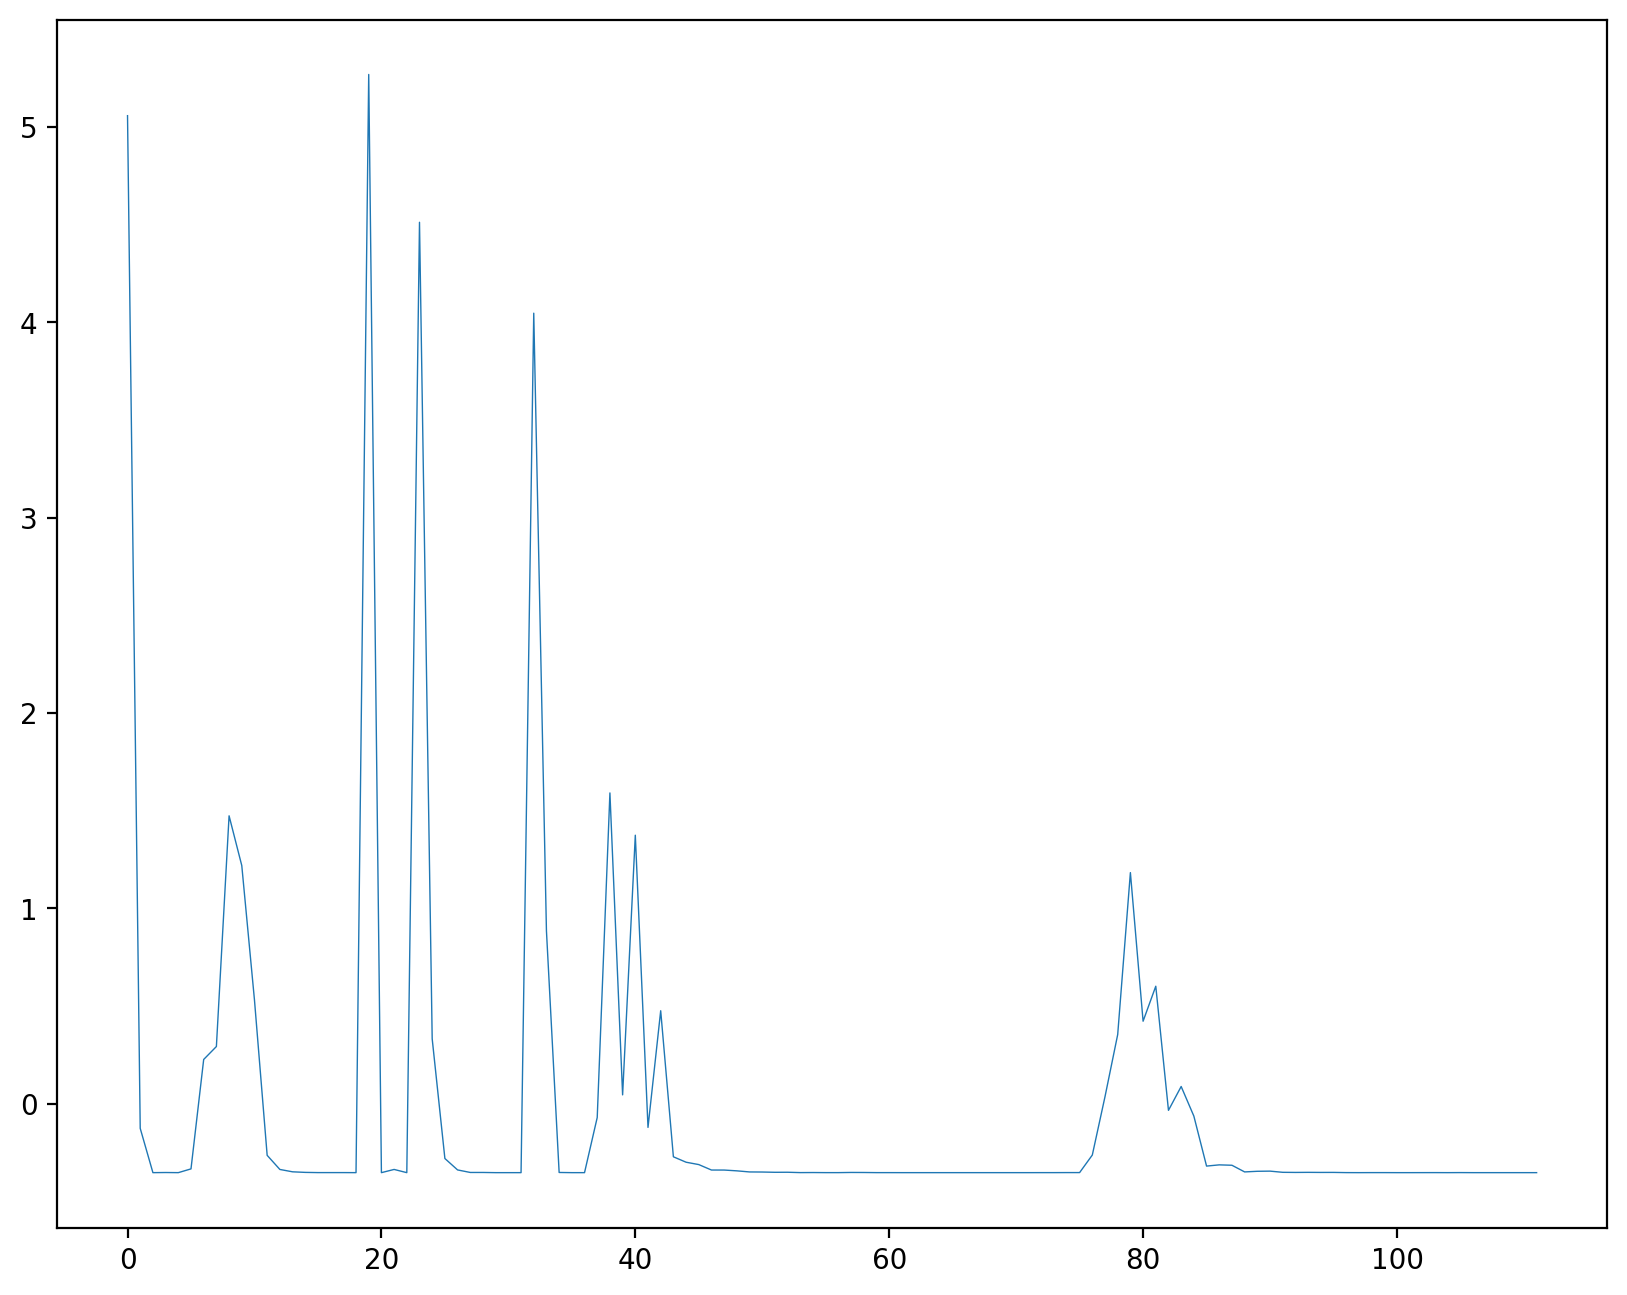

In [48]:
plt.figure(figsize = (10,8), dpi = 200)
plt.plot(all_phi[75], linewidth = 0.5)
plt.savefig(output_path + 'graphlet_degree_normalized_standardized_paris_phi.svg')

In [50]:
from sklearn.metrics import silhouette_score

silhouette_score(embed, labels), silhouette_score(all_phi, labels)
#(0.13715280276833852, 0.23220126856059697) normalized graphlet degree kernel
#(0.2349476268757523, 0.2456655234540093) normalized standardized graphlet degree kernel

(0.2349476268757523, 0.2456655234540093)